# Predict if a Tornado will be "Weak" or "Strong"🌪️
CMSC320 - Fall 2025 Data Science Project

<br>**Contributions**
*   Lawrence Lin (A, D, B): Proposed the initial idea, created the ML model, and helped in cleaning up the dataset.
*   Ethan Chung (C, E, H): Helped explore the dataset, ML training, and found variables to test.
*   Mahmoud Talass (F, G, C): Performed statistical analysis, tutorial creation, and data visualization.
*   Seth Johnston (F, D, H): Researched tornadoes for the project background, helped with creation of the ML model.

**Introduction**

Tornadoes are one of the most destructive natural disasters, causing billions of dollars (yes, billions!) in damage and claiming hundreds of lives annually in the United States. The severity of a tornado greatly impacts the emergency response necessary to mitigate the destructive effects. Two of our group members have had tornadoes negatively impact their families, completely changing their lives. For us, this project is personal. Through Data Science, we hope to focus on how people's lives are affected if a tornado is "weak" or "severe," and gain insight into what safety precautions can be taken if predicted correctly. This project seeks to answer the question: can we predict whether a tornado will be classified as "weak" (EF-0 or EF-1) or "severe" (EF-2 through EF-5) based on observable features such as geograhpic location, temporal patterns, and physical dimensions? Based on whether the tornado is "weak" or "severe," a value of 0 or 1 will be assigned to the tornado, meaning "weak" or "severe," respectively. Through our analysis of over 70,000 tornado records across multiple decades, we hope to identify key predictive factors and develop a ML model capable of accurately classifying tornado severity. By doing this, we can predict how storms disproportionately affect certain areas, allocate necessary resources to those areas, and reduce the impact of tornadoes.



In [14]:
# Importing needed libraries
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Data Curation

First, we have to find a comprehensive dataset related to tornado events (in the United States). Since we want to analyze tornado characteristics and severity, we looked for a dataset that included detailed information about historical tornado occurrences. We wanted the dataset that also included information about the magnitude, physical dimensions, locations, and temporal data of the tornadoes.

We ended up finding a dataset through the **National Alliance for Public Safety**, with the dataset being titled, "Tornadoes." This **lovely** dataset includes records of tornado events with 26 different features!! These features include [Enhanced Fujita (EF)](https://www.weather.gov/oun/efscale) scale ratings, width and length measurements, geographic location, dates and times, and a lot more. This dataset is publically accessible and provides us with 71,813 tornado records spanning across seven decades, giving us a ton of data to perform meaningful analysis and build our ML model. After downloading the data in CSV format, we loaded it into a pandas DataFrame for preprocessing and analysis.

**Source:** National Alliance for Public Safety GIS Foundation. "Tornadoes." *NAPSG PrepResponse Portal*, 30 May 2025.(https://prep-response-portal.napsgfoundation.org/datasets/0db253f3e83a4c5f9f5ab9577f2dcb49_0/explore). Accessed 22 Sep. 2025.

<br>

In [15]:
df = pd.read_csv("Tornadoes.csv")

print(f"Shape of Dataset: {df.shape}")
print(f"Number of Features: {df.shape[1]}")
print(f"Number of Entries in dataset: {df.shape[0]}")
print("----Data Types----")
print(df.dtypes.value_counts())

Shape of Dataset: (71813, 26)
Number of Features: 26
Number of Entries in dataset: 71813
----Data Types----
int64      13
float64     9
object      4
Name: count, dtype: int64


In [16]:
# Filter Invalid Data
df_clean = df[df['Magnitude'] != -9].copy()
df_clean = df_clean[(df_clean['Width (yards)'] > 0) & (df_clean['Length (miles)'] > 0)]

# Create Target Variable (is_severe)
df_clean['is_severe'] = df_clean['Magnitude'].apply(lambda x: 1 if x >= 2 else 0)

# Date Parsing
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean['DayOfYear'] = df_clean['Date'].dt.dayofyear

df_clean[['Date', 'Magnitude', 'is_severe', 'Width (yards)']].head()

,Date,Magnitude,is_severe,Width (yards)
0,1950-10-01 05:00:00,1,0,10
1,1950-10-09 05:00:00,3,1,880
2,1950-11-20 05:00:00,2,1,10
3,1950-11-20 05:00:00,1,0,10
4,1950-11-20 05:00:00,1,0,37


# Exploratory Data Analysis

Before building our machine learning model to predict tornado severity, we need to understand the key characteristics of tornadoes, find potential correlations between variables, and gain insights to make a better ML model. We looked at the following three questions: First, we analyzed the average fatality rates and [economic impacts](https://www.statista.com/statistics/237409/economic-damage-caused-by-tornadoes-in-us/?srsltid=AfmBOooHSVUmrgTK6JBiPehwBvqQKwICEX5C5dsZ17dAcnmMQJ-fKjtJ) to understand the costs of tornado events. Next, we looked to see whether there is a relationship between the time of day a tornado occurs and its magnitude, as this could reveal temporal patterns in tornado behavior. Finally,, we compared tornado widths between coastal and inland states to determine if being geographically close to large bodies of water influences tornado characteristics. Through our exploratory analysis, we wish to find which features might be the most predictive of tornado severity and guide feature selection for our ML model.

**Question 1**: What is the average (mean and median) fatality rate and economic impact of a tornado?

Median property loss: $0.08 mil
Mean property loss: $154654.42433011852 mil


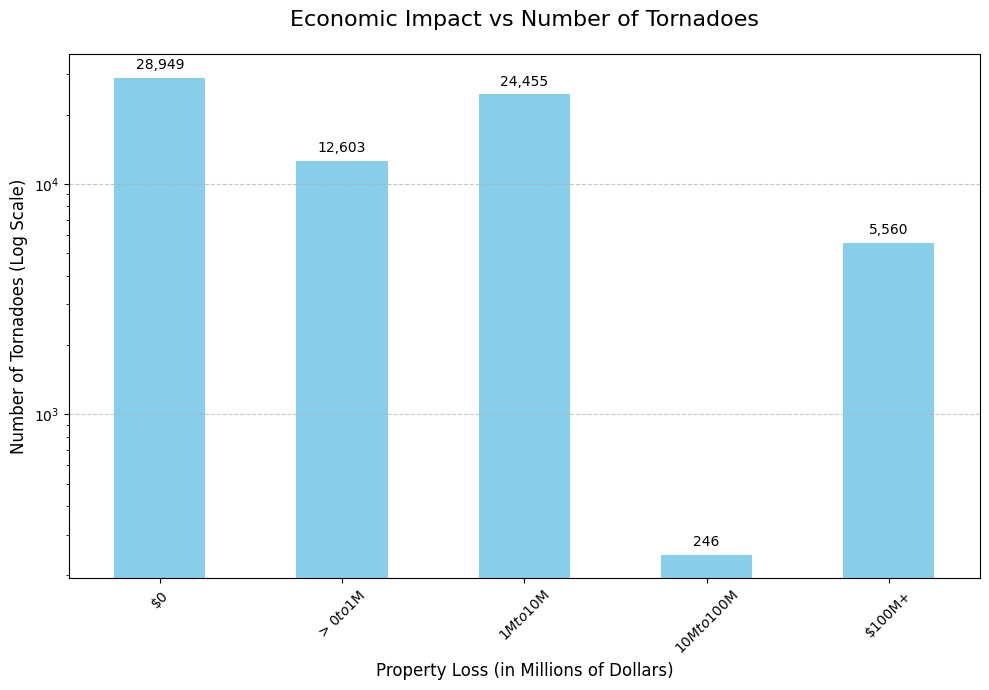

In [17]:
df['Property Loss (in millions of dollars)'] = pd.to_numeric(df['Property Loss (in millions of dollars)'], errors='coerce')
df_econ = df.dropna(subset=['Property Loss (in millions of dollars)'])

median_val = df_econ['Property Loss (in millions of dollars)'].median()
mean_val = df_econ['Property Loss (in millions of dollars)'].mean()

bins = [-np.inf, 0, 1, 10, 100, np.inf]
labels = ['$0', '> $0 to $1M', '$1M to $10M', '$10M to $100M', '$100M+']
df_econ['Loss Bin'] = pd.cut(df_econ['Property Loss (in millions of dollars)'], bins=bins, labels=labels, right=True)
econ_counts = df_econ['Loss Bin'].value_counts().sort_index()

plt.figure(figsize=(10, 7))
label = econ_counts.plot(kind='bar', color='skyblue')

plt.title('Economic Impact vs Number of Tornadoes', fontsize=16, pad=20)
plt.xlabel('Property Loss (in Millions of Dollars)', fontsize=12)
plt.ylabel('Number of Tornadoes (Log Scale)', fontsize=12)
plt.xticks(rotation=45)
plt.yscale('log')

for p in label.patches:
    label.annotate(f'{int(p.get_height()):,}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='center',
    xytext=(0, 9),
    textcoords='offset points',
    fontsize=10)

print(f"Median property loss: ${median_val} mil")
print(f"Mean property loss: ${mean_val} mil")

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Median fatalities: 0.0
Mean fatalities: 0.08735187222369209


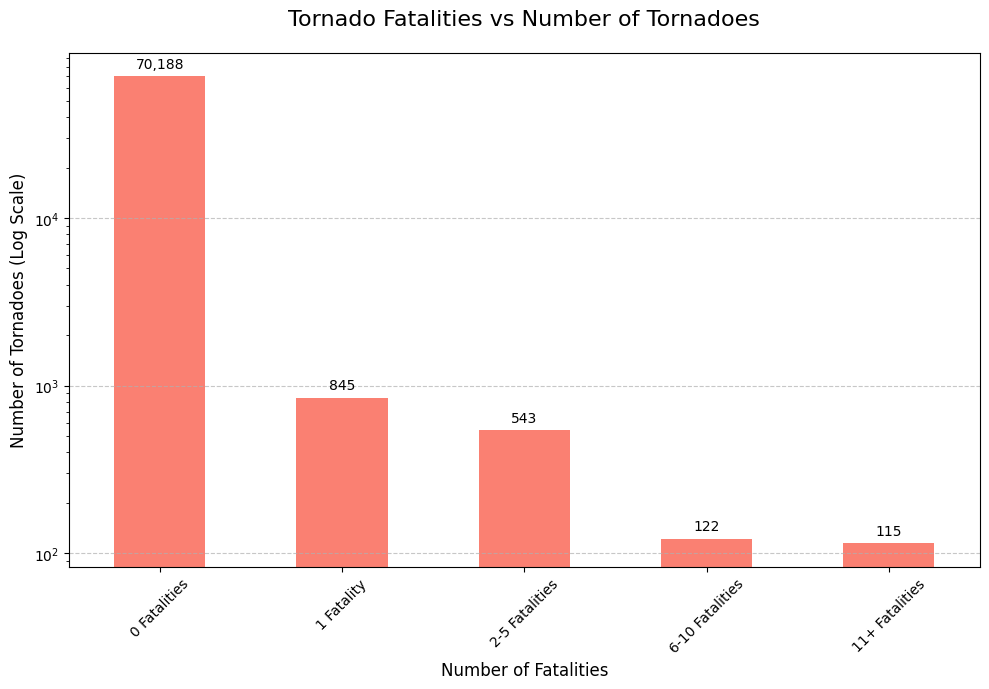

In [18]:
df_fatal = df.dropna(subset=['Fatalities'])

median_val = df_fatal['Fatalities'].median()
mean_val = df_fatal['Fatalities'].mean()

bins_fatal = [-np.inf, 0, 1, 5, 10, np.inf]
labels_fatal = ['0 Fatalities', '1 Fatality', '2-5 Fatalities', '6-10 Fatalities', '11+ Fatalities']

df_fatal['Fatality Bin'] = pd.cut(df_fatal['Fatalities'], bins=bins_fatal, labels=labels_fatal, right=True)

fatal_counts = df_fatal['Fatality Bin'].value_counts().sort_index()

plt.figure(figsize=(10, 7))
label = fatal_counts.plot(kind='bar', color='salmon')
plt.title('Tornado Fatalities vs Number of Tornadoes', fontsize=16, pad=20)
plt.xlabel('Number of Fatalities', fontsize=12)
plt.ylabel('Number of Tornadoes (Log Scale)', fontsize=12)
plt.xticks(rotation=45)
plt.yscale('log')

for p in label.patches:
    label.annotate(f'{int(p.get_height()):,}',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='center',
    xytext=(0, 9),
    textcoords='offset points',
    fontsize=10)

print(f"Median fatalities: {median_val}")
print(f"Mean fatalities: {mean_val}")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

**Conclusion 1**: Most tornadoes are brief and cause no fatalities, while a few outliers are massive and destructive which skews the data
*   Median property loss: $0.08 mil

*   Mean property loss: $154654.42 mil

*   Median fatalities: 0.0

*   Mean fatalities: 0.087

**Question 2**: Is there a relationship between time when a tornado occurs and the tornado magnitude?

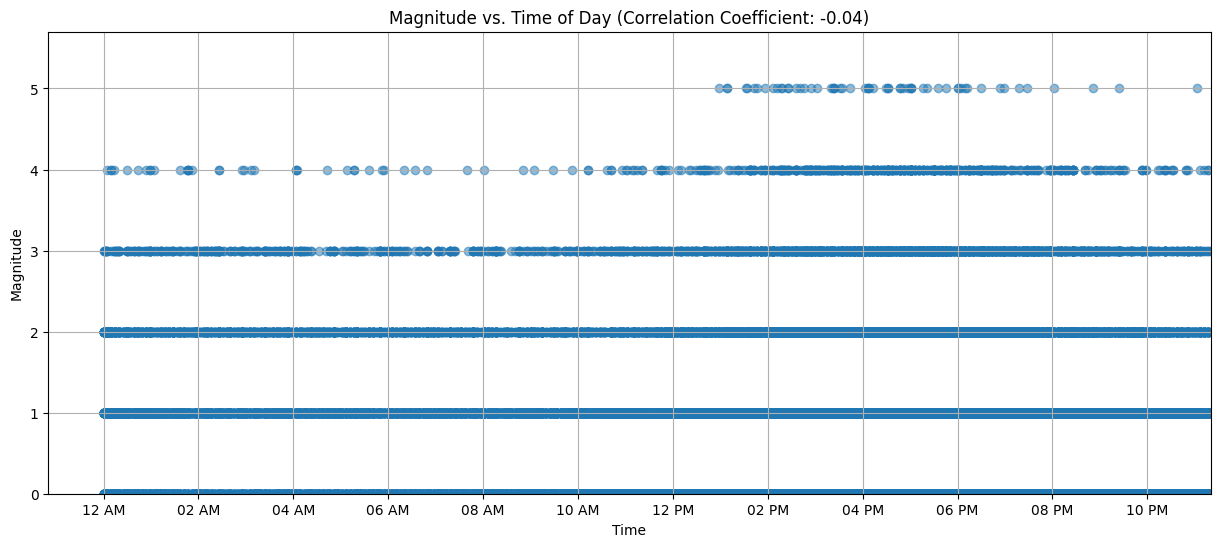

Pearson Correlation Coefficient (r): -0.036193349895432665


In [19]:
from datetime import datetime, timedelta
import time
from matplotlib.ticker import FuncFormatter, MultipleLocator

def get_hour_from_seconds(seconds, pos):
  base_time = datetime(2000, 1, 1) + timedelta(seconds)
  return time.strftime('%I %p', time.gmtime(seconds))

tornado_time_and_magnitude = df[['Time', 'Magnitude']]
tornado_time_and_magnitude['Time'] = pd.to_timedelta(tornado_time_and_magnitude['Time']).dt.total_seconds()

correlation_coefficient = tornado_time_and_magnitude['Time'].corr(df['Magnitude'])
correlation_coefficient

fig,ax = plt.subplots(figsize=(15, 6))
ax.scatter(tornado_time_and_magnitude['Time'], tornado_time_and_magnitude['Magnitude'], alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')

ax.set_title(f'Magnitude vs. Time of Day (Correlation Coefficient: {correlation_coefficient:.2f})')
ax.grid(True)

ax.set_ylim(bottom=0)
ax.set_xlim(right=86340) # limit is 23:59:00 to avoid showing 12 AM at the end
ax.xaxis.set_major_formatter(FuncFormatter(get_hour_from_seconds))
ax.xaxis.set_major_locator(MultipleLocator(7400))

plt.show()

print("Pearson Correlation Coefficient (r):" , correlation_coefficient)

**Conclusion**: The correlation coefficient of -0.036 tells us there there is essentially not relationship between the magnitude of a tornado and the time of the day when it occurs. The scatter plot shows that various magnitudes happen at various times throughout the day, indicating that magnitude and time of day are independent.

**Question 3**: Does tornado width differ from coastal to inland states?

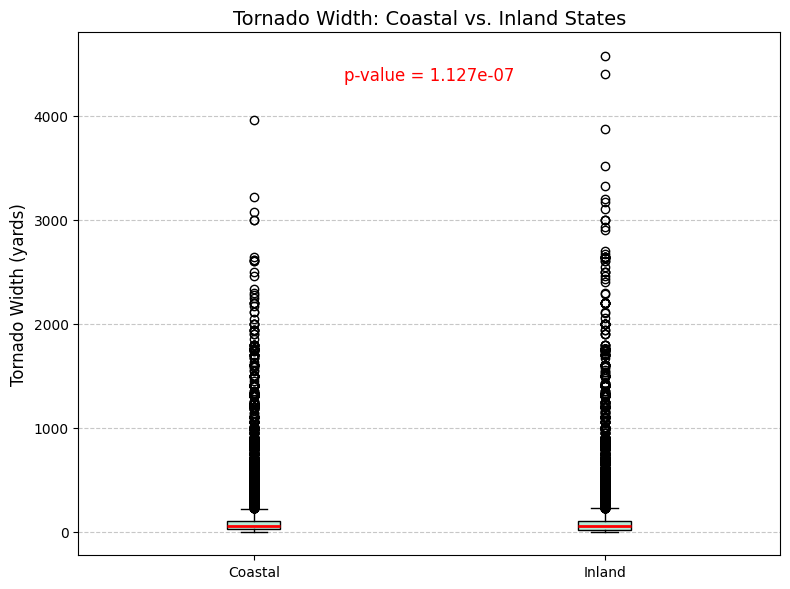

T-statistic: 5.306
P-value: 1.126511e-07
Coastal mean width: 116.24
Inland mean width: 107.67


In [20]:
from scipy.stats import ttest_ind

df["Width (yards)"] = pd.to_numeric(df["Width (yards)"], errors="coerce")

coastal_states = [
    "ME","NH","MA","RI","CT","NY","NJ","DE","MD","VA","NC","SC","GA","FL",
    "AL","MS","LA","TX","CA","OR","WA","HI","AK"
]
df["Coastal"] = df["State Abbreviation"].isin(coastal_states)

coastal = df[df["Coastal"] == True]["Width (yards)"].dropna()
inland = df[df["Coastal"] == False]["Width (yards)"].dropna()

t_stat, p_val = ttest_ind(coastal, inland, equal_var=False)

n1, n2 = len(coastal), len(inland)
s1, s2 = coastal.std(), inland.std()
pooled_sd = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))

plt.figure(figsize=(8,6))
box_data = [coastal, inland]
labels = ['Coastal', 'Inland']
plt.boxplot(
    box_data, tick_labels=labels, patch_artist=True,
    boxprops=dict(facecolor="#B5EAD7", color="black"),
    medianprops=dict(color="red", linewidth=2),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black")
)
plt.title("Tornado Width: Coastal vs. Inland States", fontsize=14)
plt.ylabel("Tornado Width (yards)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
y_max = max(coastal.max(), inland.max())
plt.text(1.5, y_max * 0.95, f"p-value = {p_val:.3e}",
         ha='center', fontsize=12, color='red')
plt.tight_layout()
plt.show()

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.6e}")
print(f"Coastal mean width: {coastal.mean():.2f}")
print(f"Inland mean width: {inland.mean():.2f}")

Conclusion: The p-value of 1.126511e-07 means that it's extremely unlikely that the difference in tornado width is random between coastal and inland states.

# Primary Analysis

Based on our exploratory analysis, we chose to implement a [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to predict whether a tornado will be classified as weak (EF-0 or EF-1) or severe (EF-2 through EF-5). Random Forest is well-suited for this classification task since it can handle multiple features simultaneously, capture non-linear relationships between variables, and is robust to outliers. These are all characteristics present in our dataset, making it a clear choice. We chose six features for our model: tornado width and length (physical dimensions), starting latitude and longitude (geographic location), day of the year (temporal data), and time of day converted to minutes (temporal pattern within a data). These features were informed by our exploratory analysis and represent characteristics that could be observed (or estimated) during a tornado. We split our dataset into 80% training data and 20% testing data, then trained the Random Forest model with 100 decision trees. This approach allows us to make predictions and identify which features are most important for distinguishing between weak and severe tornadoes.



# Machine Learning Analysis: Predicting Tornado Severity

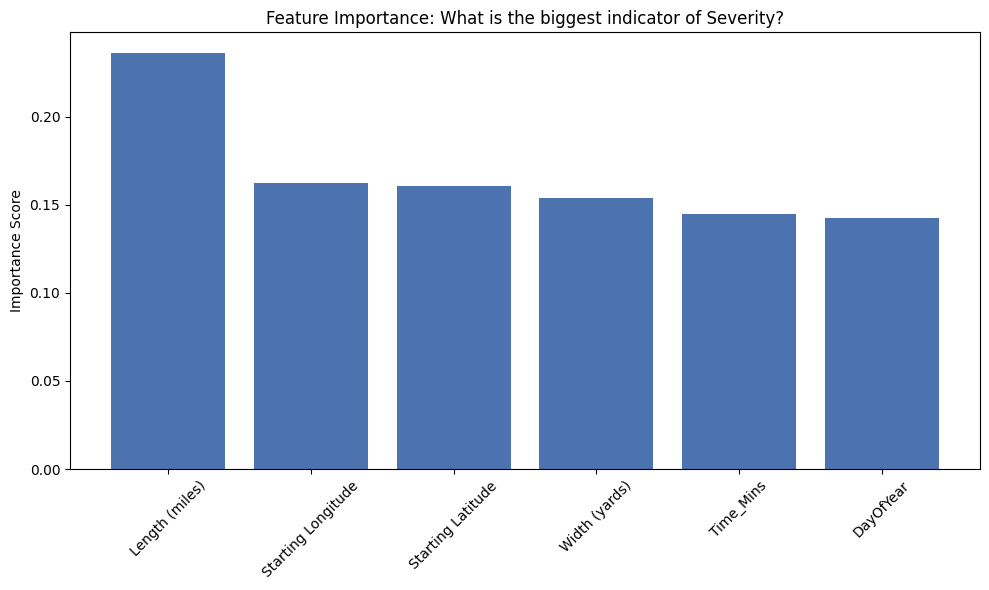

In [21]:
df_clean = df[df['Magnitude'] != -9].copy()
df_clean = df_clean[(df_clean['Width (yards)'] > 0) & (df_clean['Length (miles)'] > 0)]
df_clean['is_severe'] = df_clean['Magnitude'].apply(lambda x: 1 if x >= 2 else 0)

def time_to_minutes(t_str):
    try:
        parts = t_str.split(':')
        return int(parts[0]) * 60 + int(parts[1])
    except:
        return 0
df_clean['Time_Mins'] = df_clean['Time'].apply(time_to_minutes)
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean['DayOfYear'] = df_clean['Date'].dt.dayofyear

features = ['Width (yards)', 'Length (miles)', 'Starting Latitude',
            'Starting Longitude', 'DayOfYear', 'Time_Mins']

X = df_clean[features]
y = df_clean['is_severe']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance: What is the biggest indicator of Severity?")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='#4c72b0')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [22]:
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Weak', 'Severe']))

Model Accuracy: 84.59%

Classification Report:
              precision    recall  f1-score   support

        Weak       0.86      0.96      0.91     11387
      Severe       0.67      0.34      0.45      2608

    accuracy                           0.85     13995
   macro avg       0.77      0.65      0.68     13995
weighted avg       0.83      0.85      0.82     13995



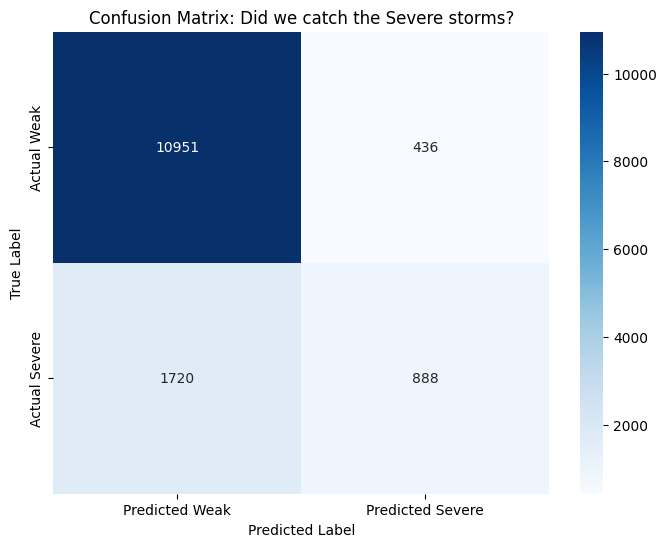

In [23]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Weak', 'Predicted Severe'],
            yticklabels=['Actual Weak', 'Actual Severe'])

plt.title('Confusion Matrix: Did we catch the Severe storms?')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Visualization

Our Random Forest model achieved an overall accuracy of 84.59% in predicting tornado severity, demonstrating the predictive capability of our model! The feature importance plot reveals which characteristics are most critical for distinguishing between weak and severe tornadoes. Width (in yards) is the most important predictor, which aligns with our intuition (larger -> more dangerous). To no one's surprise, length (in miles) emerged as the second most important predictor, as longer tornado paths also correlate with increased severity. Geographic features (starting latitude and longitude) showed moderate importance suggesting that location plays a large role in tornado intensity, possibly due to different atmospheric conditions in different regions. Temporal features (day of year and time of day) had the lowest importance scores, indicating that **when** a tornado occurs matters less than its physical characteristics for predicting severity. The classification report shows the model performs better at identifying weak tornadoes (96% recall) than severe ones (34% recall), which is expected given the class imbalance in our dataset. Weak tornadoes are more common than severe ones (thankfully)!

#Insights and Conclusion

This project aimed to predict whether a tornado would be classified as “weak” (EF-0 or EF-1) or “severe” (EF-2 through EF-5) using a dataset with over 70,000 tornado records. The analysis revealed many key findings: the median property loss per tornado was $0.08 million, and the median number of fatalities was 0.0, indicating that most tornado events are not highly destructive, though some outliers skewed the mean values significantly. An exploratory data analysis found no significant relationship between tornado magnitude and time of day, as indicated by a Pearson correlation coefficient of -0.036. However, there was a statistically significant difference in tornado width between coastal and inland states (Coastal mean width: 116.24 yards, Inland mean width: 107.67 yards, with a p-value of 1.127e-07). The final Random Forest Classifier achieved an overall accuracy of 84.59% in predicting tornado severity. Tornado width and length were found to be the most critical predictors of severity, while temporal features (day and time) were the least important, suggesting that a tornado’s physical dimensions are the best indicators of its destructive potential. Though the model performed better at identifying weak tornadoes (96% recall) than severe ones (34% recall) due to class imbalance, this combination of clear context and deep, quantitative analysis ensures that both an uninformed reader gains foundational knowledge about tornado characteristics and a more informed reader learns new, specific, data-driven insights regarding feature importance and model performance.